### Make teleconnection patterns with 20CR for each method, temp and precip

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import sys
sys.path.append('/home/563/rl5183/PhD-research/Functions')
import functions as func
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
# Read in the quadratically detrended 20CR temp
temp = xr.open_dataarray('/g/data/w40/rl5183/20CR_tmp_ensemble_mean_quad_detrend_1.5x1.5.nc')
# Calculate anomalies
clim = temp.sel(time=slice('1979-01', '2008-12')).groupby('time.month').mean()
anom = (temp.groupby('time.month') - clim)
# Take DJF average
quarterly_anom = anom.resample(time='QS-DEC').mean('time')
djf_anom = quarterly_anom.isel(time=slice(0,None,4))
# NINO indices from Hadisst
sst = xr.open_dataset('/g/data/w40/rl5183/hadisst.1870_2017_1.5x1.5.nc').sst
# Detrend 
sst_detrend = np.apply_along_axis(func.quad_detrend, 0, sst)
sst_dt = xr.DataArray(sst_detrend, coords=sst.coords, attrs=sst.attrs)
# Calculate EP and CP index
nino3 = func.nino3_index(sst_dt, '1979-01', '2008-12')
nino4 = func.nino4_index(sst_dt, '1979-01', '2008-12')
# Calculate EP and CP index
EP_sst = (nino3 - 0.5*nino4).sel(time=slice('1900-01', '2014-12'))
CP_sst = (nino4 - 0.5*nino3).sel(time=slice('1900-01', '2014-12'))
# Take DJF average of EP index and CP index
quarterly_EP = EP_sst.resample(time='QS-DEC').mean('time')
djf_EP = quarterly_EP.isel(time=slice(0,None,4))
djf_EP = djf_EP/djf_EP.std()

quarterly_CP = CP_sst.resample(time='QS-DEC').mean('time')
djf_CP = quarterly_CP.isel(time=slice(0,None,4))
djf_CP = djf_CP/djf_CP.std()
# Regression
EP_regress_20CR = func.regress_nino(djf_anom, djf_EP)
CP_regress_20CR = func.regress_nino(djf_anom, djf_CP)

In [3]:
# Open HadISST 
sst_ds = xr.open_dataset('/g/data/w40/rl5183/hadisst.1870_2017_1.5x1.5.nc')
sst = sst_ds.sst.sel(lat=slice(-15,15)).sel(lon=slice(140,280)).sel(time=slice('1900-01', '2014-12'))
# Quadtratically Detrend 
sst_detrend = np.apply_along_axis(func.quad_detrend, 0, sst)
sst_dt = xr.DataArray(sst_detrend, coords=sst.coords, attrs=sst.attrs)
# Calculate anomalies 
clim = sst_dt.sel(time=slice('1979-01', '2008-12')).groupby('time.month').mean()
anom = sst_dt.groupby('time.month') - clim
# EOFs
had_eof, had_pcs, had_var = func.eof_and_pcs(anom, 3)
# Scale PCs to have a standrd deviation of 1 
had_pc1 = (had_pcs.sel(mode=1)/had_pcs.sel(mode=1).std())*-1
had_pc2 = had_pcs.sel(mode=2)/had_pcs.sel(mode=2).std()
# Calculate E-index and C-index
had_E = (had_pc1 - had_pc2)/np.sqrt(2)
had_C = (had_pc1 + had_pc2)/np.sqrt(2)
# Take DJF average of E-index and C-index
had_quarterly_E = had_E.resample(time='QS-DEC').mean('time')
had_djf_E = had_quarterly_E.isel(time=slice(0,None,4))
had_djf_E = had_djf_E/had_djf_E.std()

had_quarterly_C = had_C.resample(time='QS-DEC').mean('time')
had_djf_C = had_quarterly_C.isel(time=slice(0,None,4))
had_djf_C = had_djf_C/had_djf_C.std()

# Regression
E_regress_20CR = func.regress_nino(djf_anom, had_djf_E)
C_regress_20CR = func.regress_nino(djf_anom, had_djf_C)

In [27]:
def format_gridlines(ax, top_labels=False, bottom_labels=False, left_labels=False, right_labels=False):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.75, linestyle='--')
    gl.top_labels = top_labels
    gl.bottom_labels = bottom_labels
    gl.right_labels = right_labels
    gl.left_labels = left_labels
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    return ax

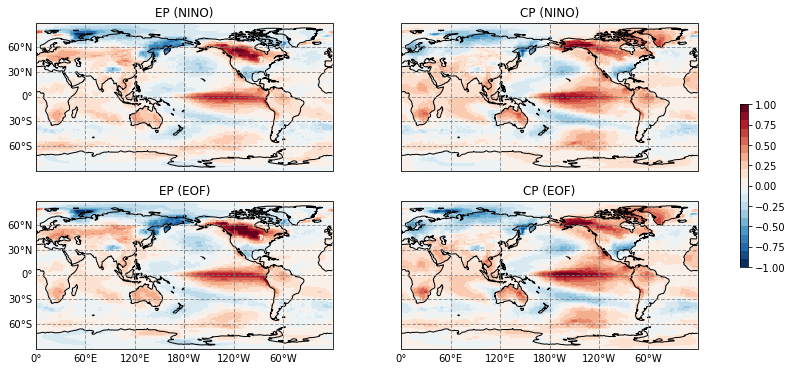

In [6]:
fig = plt.figure(figsize = (15,6)) 
axs = []
ax = fig.add_subplot(221, projection=ccrs.PlateCarree(180))
im = EP_regress_20CR.plot(ax=ax, vmin=-1, vmax=1, cmap=plt.cm.get_cmap('RdBu_r', 20), add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('EP (NINO)')
ax = format_gridlines(ax, left_labels=True)
axs.append(ax)
ax = fig.add_subplot(222, projection=ccrs.PlateCarree(180))
im = CP_regress_20CR.plot(ax=ax, vmin=-1, vmax=1, cmap=plt.cm.get_cmap('RdBu_r', 20), add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('CP (NINO)')
ax = format_gridlines(ax)
axs.append(ax)
ax = fig.add_subplot(223, projection=ccrs.PlateCarree(180))
im = E_regress_20CR.plot(ax=ax, vmin=-1, vmax=1, cmap=plt.cm.get_cmap('RdBu_r', 20), add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('EP (EOF)')
ax = format_gridlines(ax, left_labels=True, bottom_labels=True)
axs.append(ax)
ax = fig.add_subplot(224, projection=ccrs.PlateCarree(180))
im = C_regress_20CR.plot(ax=ax, vmin=-1, vmax=1, cmap=plt.cm.get_cmap('RdBu_r', 20), add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('CP (EOF)')
ax = format_gridlines(ax, bottom_labels=True)
axs.append(ax)
# Formatting
cbar = plt.colorbar(im, ax=axs, shrink=0.5, pad=0.05)

#plt.savefig('20CR_mean_temp_teleconnection_EP_CP_NINO_EOF', bbox_inches='tight', dpi=300)

In [13]:
# Pattern corr
E = func.pattern_cor(EP_regress_20CR, E_regress_20CR)
C = func.pattern_cor(CP_regress_20CR, C_regress_20CR)
print(f'E:{E}')
print(f'C:{C}')

E:0.9781408609466358
C:0.9823424149347215


In [23]:
diff = CP_regress_20CR - EP_regress_20CR

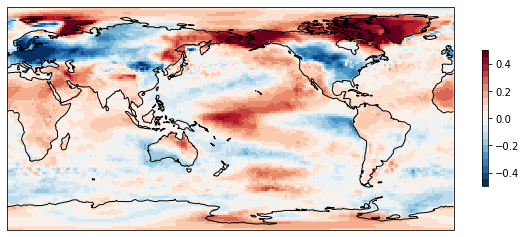

In [24]:
fig = plt.figure(figsize=(10,5)) 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(180))
im = diff.plot(ax=ax, vmin=-0.5, vmax=0.5, cmap=plt.cm.get_cmap('RdBu_r', 20), add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(im, ax=ax, shrink=0.5, pad=0.05)

In [25]:
# Read in the 20CR precip
precip = xr.open_dataarray('/g/data/w40/rl5183/20CR_pr_ensemble_mean_1.5x1.5.nc').sel(time=slice('1900-01', '2014-12'))*86400
# Calculate anomalies
clim = precip.sel(time=slice('1979-01', '2008-12')).groupby('time.month').mean()
anom = (precip.groupby('time.month') - clim)
# Take DJF average
quarterly_anom = anom.resample(time='QS-DEC').mean('time')
djf_anom = quarterly_anom.isel(time=slice(0,None,4))
# Regression
EP_regress_20CR = func.regress_nino(djf_anom, djf_EP)
CP_regress_20CR = func.regress_nino(djf_anom, djf_CP)
E_regress_20CR = func.regress_nino(djf_anom, had_djf_E)
C_regress_20CR = func.regress_nino(djf_anom, had_djf_C)

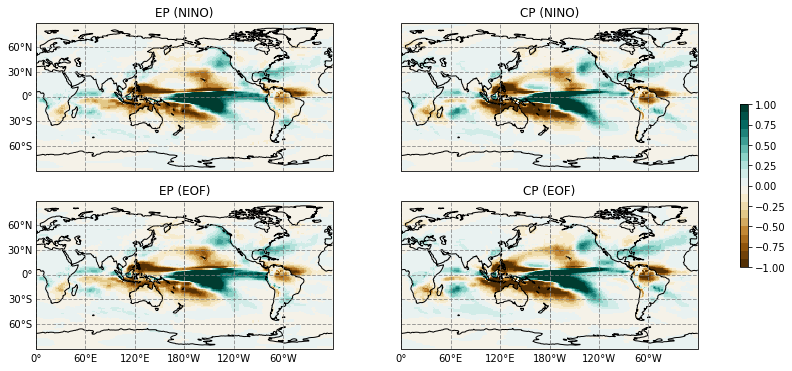

In [34]:
fig = plt.figure(figsize = (15,6)) 
axs = []
ax = fig.add_subplot(221, projection=ccrs.PlateCarree(180))
im = EP_regress_20CR.plot(ax=ax, vmin=-1, vmax=1, cmap=plt.cm.get_cmap('BrBG', 20), add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('EP (NINO)')
ax = format_gridlines(ax, left_labels=True)
axs.append(ax)
ax = fig.add_subplot(222, projection=ccrs.PlateCarree(180))
im = CP_regress_20CR.plot(ax=ax, vmin=-1, vmax=1, cmap=plt.cm.get_cmap('BrBG', 20), add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('CP (NINO)')
ax = format_gridlines(ax)
axs.append(ax)
ax = fig.add_subplot(223, projection=ccrs.PlateCarree(180))
im = E_regress_20CR.plot(ax=ax, vmin=-1, vmax=1, cmap=plt.cm.get_cmap('BrBG', 20), add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('EP (EOF)')
ax = format_gridlines(ax, left_labels=True, bottom_labels=True)
axs.append(ax)
ax = fig.add_subplot(224, projection=ccrs.PlateCarree(180))
im = C_regress_20CR.plot(ax=ax, vmin=-1, vmax=1, cmap=plt.cm.get_cmap('BrBG', 20), add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('CP (EOF)')
ax = format_gridlines(ax, bottom_labels=True)
axs.append(ax)
# Formatting
cbar = plt.colorbar(im, ax=axs, shrink=0.5, pad=0.05)

#plt.savefig('20CR_mean_precip_teleconnection_EP_CP_NINO_EOF', bbox_inches='tight', dpi=300)

In [29]:
# Pattern corr
E = func.pattern_cor(EP_regress_20CR, E_regress_20CR)
C = func.pattern_cor(CP_regress_20CR, C_regress_20CR)
print(f'E:{E}')
print(f'C:{C}')

E:0.9929206715399481
C:0.9958025476313556


In [30]:
diff = CP_regress_20CR - EP_regress_20CR

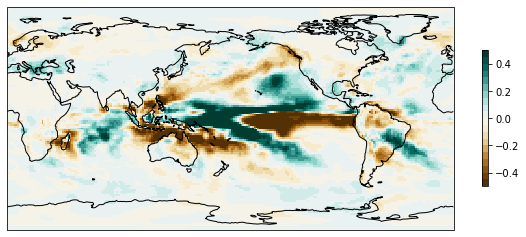

In [33]:
fig = plt.figure(figsize=(10,5)) 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(180))
im = diff.plot(ax=ax, vmin=-0.5, vmax=0.5, cmap=plt.cm.get_cmap('BrBG', 20), add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(im, ax=ax, shrink=0.5, pad=0.05)